# MTA Subway Origin-Destination Ridership Estimate: 2023
Author: Mark Bauer  
New York State Open Data: https://data.ny.gov/Transportation/MTA-Subway-Origin-Destination-Ridership-Estimate-2/uhf3-t34z/about_data

Quick description about the dataset from the data dictionary:
>This dataset provides an estimate of subway travel patterns based on scaled-up OMNY and MetroCard
return tap and swipe data for 2023. It will provide estimated passenger volumes for all populated origindestination (OD) pairs aggregated by month, day of the week, and hour of day. It also provides the
name, ID, and approximate latitude and longitude of the origin and destination subway complexes.

Additionally, the MTA wrote an article introducing the dataset that I've found useful and informative. In particular, how the dataset is aggregated. For example: **The format of this aggregated dataset allows users to understand for “an average 9 a.m. hour during the month of May,” roughly how many people travelled between two subway complexes.**
> **About the data**  
Let’s talk a bit more about the data. This dataset is based off of the ‘Destination Inference’ step of our ridership model, which we detailed in a [previous blog post](https://new.mta.info/article/where-everybody-subway-going). As that post outlines, the basis of this model is the assumption that a subway trip’s destination is the station the rider next swipes/taps at. If a MetroCard swipes into Bowling Green at 9:15 a.m., and then that same MetroCard swipes into the 103 St stop in East Harlem later that afternoon, we make the imperfect (but pretty good) inference that this 9:15 a.m. trip traveled from Bowling Green to 103 St. These “linked trips” are what form the basis of our understanding of how riders travel across the system (Note 1).
>
>In this Subway Origin-Destination (OD) dataset, we’ve taken these assigned destinations generated by our destination inference process and aggregated them by origin-destination station complex pair and hour of day. These totals are then further aggregated by averaging over a calendar month. Removing personally identifying information, like MetroCard ID numbers, and aggregating ridership data over a calendar month is done to protect the privacy of MTA riders by preventing the association of a single MetroCard swipe or subway trip to a specific person or hour. The format of this aggregated dataset allows users to understand for “an average 9 a.m. hour during the month of May,” roughly how many people travelled between two subway complexes.
>
>It’s important to keep a few things in mind when using this data: 
>
>Because this data is the result of a modeling process, the ridership numbers for each origin-destination pair are estimates, not exact values. This modeling process, as well as the monthly aggregation, results in fractional ridership values—we’ve intentionally left ridership estimates as decimals to reflect the uncertainty inherent in this dataset. 
Because this data represents a monthly average, users should be mindful that holidays, construction, or other important events that take place during a given month might impact ridership estimates. 
Since the modeling process only looks at subway station entries, we can’t quantify how many of these trips truly started and ended at these subway station complexes and how many may have included a transfer from or to another mode of transit (e.g. a bus) at either or both ends. 
When using the data to look at arrivals to a subway station, users should note that the timestamp for each OD pair is rounded down to the nearest hour of the entry swipe (or tap) and does not account for the travel time between the entry swipe and arrival at the destination (Note 2).

Source: [Introducing the Subway Origin-Destination Ridership dataset](https://new.mta.info/article/introducing-subway-origin-destination-ridership-dataset)

![dataset-screenshot](images/dataset-screenshot.png)

Source: https://data.ny.gov/Transportation/MTA-Subway-Origin-Destination-Ridership-Estimate-2/uhf3-t34z/about_data

In [1]:
import duckdb
import urllib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p duckdb,urllib.request,seaborn,matplotlib

printing packages and versions:

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb        : 1.0.0
urllib.request: 3.11
seaborn       : 0.12.1
matplotlib    : 3.6.2



In [3]:
# list filels
%ls

LICENSE
MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
README.md
data-exporter.py
export-log.txt
figures/
images/
subway-trips.db
subway-trips.ipynb


In [4]:
# list file sizes
!du -sh *

4.0K	LICENSE
192K	MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
128K	MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
8.0K	README.md
4.0K	data-exporter.py
 16K	export-log.txt
976K	figures
392K	images
2.5G	subway-trips.db
712K	subway-trips.ipynb


# Download dataset overview and data dictionary files

In [5]:
# download dataset overview
url = 'https://data.ny.gov/api/views/uhf3-t34z/files/5be7cd3f-8f71-41a1-9923-a43f6dcb6276?download=true&filename=MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf'
urllib.request.urlretrieve(url, 'MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf')

# download data dictionary
url = 'https://data.ny.gov/api/views/uhf3-t34z/files/846e53a2-6555-4655-80b6-07fb55f234f1?download=true&filename=MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf'
urllib.request.urlretrieve(url, 'MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf')

# sanity check
%ls

LICENSE
MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
README.md
data-exporter.py
export-log.txt
figures/
images/
subway-trips.db
subway-trips.ipynb


# Create a DuckDB database instance

In [6]:
# create a DuckDB database instance
con = duckdb.connect("subway-trips.db")

# Preview data

In [7]:
%%time

# preview data
con.sql("SELECT COUNT(*) AS count_rows FROM trips").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│  115731896 │
└────────────┘

CPU times: user 95.6 ms, sys: 29.5 ms, total: 125 ms
Wall time: 24.7 ms


In [8]:
# examine columns and column types
con.sql("DESCRIBE trips").show()

┌──────────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│           column_name            │ column_type │  null   │   key   │ default │  extra  │
│             varchar              │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ year                             │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ month                            │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ day_of_week                      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ hour_of_day                      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ timestamp                        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ origin_station_complex_id        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ origin_station_complex_name      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │

In [9]:
# # examine approx. column statistics
# summarize_df = con.sql("SUMMARIZE trips").df()

# summarize_df

# Highest Estimated Average Hourly Ridership Trips

In [10]:
# preview column names
con.sql("""
    SELECT *
    FROM trips
    ORDER BY estimated_average_ridership
    DESC
    LIMIT 1
""").df()

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
0,2023,9,Tuesday,8,2023-09-05T08:00:00.000,610,"Grand Central-42 St (S,4,5,6,7)",40.751992,-73.977359,628,"Fulton St (A,C,J,Z,2,3,4,5)",40.710089,-74.007838,1634.1387,POINT (-73.977359 40.751992),POINT (-74.007838 40.710089)


In [11]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 1
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8


Table 1. Highest Estimated Average Hourly Ridership for 2023.

In [12]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,10,Wednesday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1535.4376,10,Tuesday,8
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,7,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,5,Tuesday,8
8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,8,Tuesday,8
9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.0227,11,Tuesday,8


Table 2: Top 20 Highest Estimated Average Hourly Ridership for 2023.

In [13]:
con.sql("""

    WITH month_trips as (
        SELECT
            DISTINCT ON (month)
            month,
            origin_station_complex_name,
            destination_station_complex_name,
            estimated_average_ridership,
            day_of_week,
            hour_of_day
        FROM trips
        ORDER BY estimated_average_ridership DESC
        LIMIT 20
    )
    
    SELECT * from month_trips ORDER BY month ASC
    
""").df()

,month,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,day_of_week,hour_of_day
0,1,"34 St-Penn Station (A,C,E)","5 Av/53 St (E,M)",1437.0160,Tuesday,8
1,2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1281.4100,Wednesday,8
2,3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1404.1932,Wednesday,8
3,4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1393.5625,Tuesday,8
4,5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,Tuesday,8
5,6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,Tuesday,8
6,7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,Wednesday,8
7,8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,Tuesday,8
8,9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,Tuesday,8
9,10,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,Wednesday,8


Table 3. Highest Estimated Average Hourly Ridership per Month for 2023.

In [14]:
con.sql("""

    WITH week_trips AS (
        SELECT
            DISTINCT ON (day_of_week)
            day_of_week,
            origin_station_complex_name,
            destination_station_complex_name,
            estimated_average_ridership,
            month,
            hour_of_day
        FROM trips
        ORDER BY estimated_average_ridership DESC
        LIMIT 20
    )
    
    SELECT *
    FROM week_trips
    ORDER BY array_position(
        array[
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday'],
        day_of_week::VARCHAR
    )
    
""").df()

,day_of_week,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,hour_of_day
0,Monday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",942.4655,11,8
1,Tuesday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,8
2,Wednesday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,8
3,Thursday,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1367.4580,9,8
4,Friday,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",524.8005,7,21
5,Saturday,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",322.3112,12,16
6,Sunday,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",355.5740,5,16


Table 4. Highest Estimated Average Hourly Ridership per Day of Week for 2023.

In [15]:
con.sql("""

    WITH hour_trips AS (
        SELECT
            DISTINCT ON (hour_of_day)
            hour_of_day,
            origin_station_complex_name,
            destination_station_complex_name,
            estimated_average_ridership,
            month,
            day_of_week
        FROM trips
        ORDER BY estimated_average_ridership DESC
        LIMIT 24
    )
    
    SELECT * FROM hour_trips ORDER BY hour_of_day ASC
    
""").df()

,hour_of_day,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week
0,0,Mets-Willets Point (7),"Grand Central-42 St (S,4,5,6,7)",110.9565,9,Sunday
1,1,Mets-Willets Point (7),Flushing-Main St (7),80.0948,6,Saturday
2,2,"W 4 St-Wash Sq (A,C,E,B,D,F,M)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",36.4235,6,Saturday
3,3,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",17.2865,9,Sunday
4,4,103 St-Corona Plaza (7),"74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",48.3472,12,Friday
5,5,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",99.4730,12,Wednesday
6,6,"34 St-Penn Station (1,2,3)","Grand Central-42 St (S,4,5,6,7)",329.0864,1,Tuesday
7,7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",902.1712,10,Tuesday
8,8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday
9,9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",735.4888,10,Tuesday


Table 5. Highest Estimated Average Hourly Ridership per Hour of Day for 2023.

In [16]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE day_of_week IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",355.5740,5,Sunday,16
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",322.3112,12,Saturday,16
2,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",311.7885,8,Saturday,23
3,"161 St-Yankee Stadium (B,D,4)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",307.0823,8,Sunday,17
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",297.7674,12,Saturday,13
5,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",293.4713,8,Saturday,15
6,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),291.5284,4,Saturday,15
7,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),291.3728,4,Saturday,14
8,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",290.8654,12,Saturday,12
9,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",286.1845,5,Sunday,16


Table 6. Top 20 Highest Estimated Average Hourly Ridership on Saturday and Sunday for 2023.

In [17]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE (hour_of_day BETWEEN 11 AND 13)
        AND day_of_week NOT IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",252.2272,12,Wednesday,12
1,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",243.7048,12,Wednesday,13
2,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",236.9817,12,Thursday,13
3,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",234.5605,12,Thursday,12
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",233.7728,12,Friday,13
5,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",229.6867,12,Thursday,11
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",229.0428,10,Wednesday,11
7,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",228.6570,12,Friday,11
8,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",225.3508,12,Friday,12
9,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",219.2475,12,Tuesday,12


Table 7. Top 20 Highest Estimated Average Hourly Ridership from Monday to Friday Lunch Hours (11AM to 1PM) for 2023.

In [18]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE hour_of_day < 5
        AND day_of_week NOT IN ('Friday', 'Saturday', 'Sunday')
        AND origin_station_complex_name NOT IN ('Mets-Willets Point (7)', '161 St-Yankee Stadium (B,D,4)')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",86.9527,12,Wednesday,0
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",76.2750,8,Wednesday,0
2,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",70.8650,7,Wednesday,0
3,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",69.8233,6,Wednesday,0
4,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",68.9252,12,Thursday,0
5,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",66.5818,8,Thursday,0
6,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",64.9905,12,Tuesday,0
7,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",63.6540,7,Tuesday,0
8,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",62.9850,7,Thursday,0
9,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",62.8148,10,Wednesday,0


Table 8. Top 20 Highest Estimated Average Hourly Ridership during Weekday After Hours (excluding Yankees and Mets games) for 2023.

In [19]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE hour_of_day < 5
        AND day_of_week IN ('Saturday')
        AND origin_station_complex_name NOT IN ('Mets-Willets Point (7)', '161 St-Yankee Stadium (B,D,4)')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",98.9066,12,Saturday,0
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",98.1712,8,Saturday,0
2,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",93.1244,7,Saturday,0
3,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",92.6993,11,Saturday,0
4,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",92.4350,10,Saturday,0
5,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Bedford Av (L),85.0970,10,Saturday,0
6,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",84.3212,9,Saturday,0
7,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",80.0780,5,Saturday,0
8,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,...",79.5535,6,Saturday,0
9,1 Av (L),Bedford Av (L),74.8545,10,Saturday,0


Table 9. Top 20 Highest Estimated Average Hourly Ridership for Saturday After Hours (excluding Yankees and Mets games) for 2023.

# Case Study: Grand Central Station

In [20]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,10,Wednesday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1535.4376,10,Tuesday,8
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,7,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,5,Tuesday,8
8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,8,Tuesday,8
9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.0227,11,Tuesday,8


Table 10. Top 20 Highest Average Hourly Ridership from Grand Central Station in 2023.

All of the trips are from Grand Central to Fulton Street. Let's look at unique trip combinations instead.

In [21]:
grand_central_top = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_top

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","34 St-Penn Station (1,2,3)",1090.7252,1,Tuesday,17
2,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",776.9200,9,Thursday,17
3,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),718.3783,9,Wednesday,8
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",578.8584,10,Tuesday,18
5,"Grand Central-42 St (S,4,5,6,7)","Brooklyn Bridge-City Hall (4,5,6)/Chambers St ...",574.0610,10,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Bowling Green (4,5)",541.8905,10,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",536.0848,6,Tuesday,17
8,"Grand Central-42 St (S,4,5,6,7)","Wall St (4,5)",462.5685,10,Wednesday,8
9,"Grand Central-42 St (S,4,5,6,7)",Vernon Blvd-Jackson Av (7),405.2100,10,Tuesday,17


Table 11. Top 20 Highest Average Hourly Ridership from Grand Central Station.

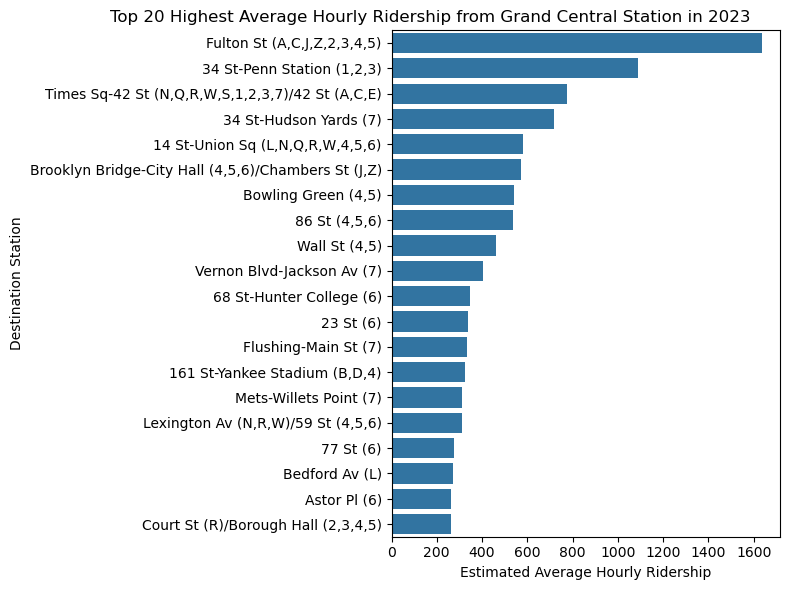

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_top, 
    y='destination_station_complex_name', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership from Grand Central Station in 2023',
    fontsize=12, x=.1
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station')

plt.tight_layout()
plt.savefig('figures/grand-central-origin.png', dpi=200, bbox_inches='tight')

Figure 1: Top 20 Highest Average Hourly Ridership from the Grand Central Station in 2023.

In [23]:
con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE
        origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",297.7674,12,Saturday,13
1,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),266.2130,9,Saturday,10
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",261.4457,5,Sunday,12
3,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",243.7718,12,Saturday,18
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",182.5640,12,Saturday,11
5,"Grand Central-42 St (S,4,5,6,7)","Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",163.4914,12,Saturday,12
6,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",157.0752,12,Saturday,12
7,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),146.1660,10,Saturday,9
8,"Grand Central-42 St (S,4,5,6,7)","Canal St (J,N,Q,R,W,Z,6)",138.4766,12,Saturday,11
9,"Grand Central-42 St (S,4,5,6,7)",Spring St (6),123.9372,12,Saturday,12


Table 12. Top 20 Highest Average Hourly Ridership on Saturday and Sunday from Grand Central Station.

In [24]:
grand_central_origin = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name) origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week = 'Saturday'
        AND month = '6'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_origin

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",197.5125,6,Saturday,12
1,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",190.5900,6,Saturday,19
2,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),179.5778,6,Saturday,15
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",170.3873,6,Saturday,14
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",123.0657,6,Saturday,15
5,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",117.3647,6,Saturday,13
6,"Grand Central-42 St (S,4,5,6,7)","Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",111.1770,6,Saturday,13
7,"Grand Central-42 St (S,4,5,6,7)","Canal St (J,N,Q,R,W,Z,6)",110.6037,6,Saturday,12
8,"Grand Central-42 St (S,4,5,6,7)",Spring St (6),89.4815,6,Saturday,12
9,"Grand Central-42 St (S,4,5,6,7)",Bedford Av (L),84.8360,6,Saturday,13


Table 13: Top 20 Highest Average Hourly Ridership on Saturdays from Grand Central Station in June 2023.

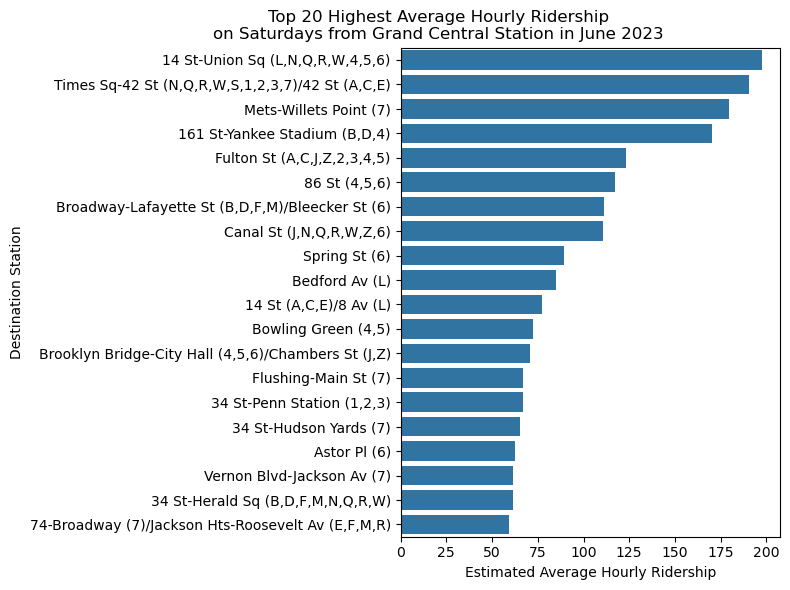

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_origin, 
    y='destination_station_complex_name', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership\non Saturdays from Grand Central Station in June 2023',
    fontsize=12, x=.1
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station')

plt.tight_layout()
plt.savefig('figures/grand-central-saturday-june.png', dpi=200, bbox_inches='tight')

Figure 2: Top 20 Highest Average Hourly Ridership on Saturdays from Grand Central Station in June 2023.

In [26]:
grand_central_destination = con.sql("""
    SELECT
        DISTINCT ON (origin_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week = 'Saturday'
        AND month = '6'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_destination

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,Mets-Willets Point (7),"Grand Central-42 St (S,4,5,6,7)",218.6620,6,Saturday,19
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","Grand Central-42 St (S,4,5,6,7)",215.9083,6,Saturday,22
2,"14 St-Union Sq (L,N,Q,R,W,4,5,6)","Grand Central-42 St (S,4,5,6,7)",163.4510,6,Saturday,14
3,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",162.1230,6,Saturday,18
4,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",132.2505,6,Saturday,16
5,"86 St (4,5,6)","Grand Central-42 St (S,4,5,6,7)",123.7598,6,Saturday,13
6,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)","Grand Central-42 St (S,4,5,6,7)",95.5373,6,Saturday,16
7,"Canal St (J,N,Q,R,W,Z,6)","Grand Central-42 St (S,4,5,6,7)",92.4135,6,Saturday,17
8,Spring St (6),"Grand Central-42 St (S,4,5,6,7)",89.4755,6,Saturday,16
9,"Lexington Av (N,R,W)/59 St (4,5,6)","Grand Central-42 St (S,4,5,6,7)",84.1985,6,Saturday,15


Table 14: Top 20 Highest Average Hourly Ridership on Saturdays to Grand Central Station in June 2023.

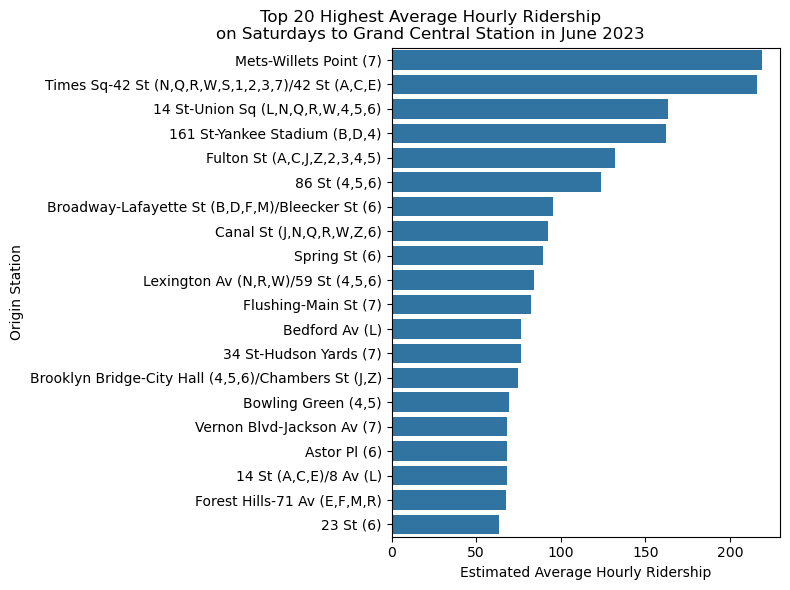

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_destination, 
    y='origin_station_complex_name', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Highest Average Hourly Ridership\non Saturdays to Grand Central Station in June 2023',
    fontsize=12, x=.1
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Origin Station')

plt.tight_layout()
# plt.savefig('figures/grand-central-destination-saturday-june.png', dpi=200, bbox_inches='tight')

Figure 2: Top 20 Highest Average Hourly Ridership on Saturdays to Grand Central Station in June 2023.

In [28]:
grand_central_destination = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND origin_station_complex_name = 'Fulton St (A,C,J,Z,2,3,4,5)'
        AND month = '6'
    ORDER BY estimated_average_ridership DESC
""").df()

grand_central_destination

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1227.9920,6,Tuesday,17
1,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1052.4918,6,Wednesday,17
2,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",968.6967,6,Wednesday,8
3,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",958.7180,6,Tuesday,8
4,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",853.4286,6,Thursday,17
...,...,...,...,...,...,...
161,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1.3165,6,Tuesday,1
162,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1.2915,6,Sunday,2
163,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",0.9250,6,Thursday,2
164,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",0.5625,6,Tuesday,2


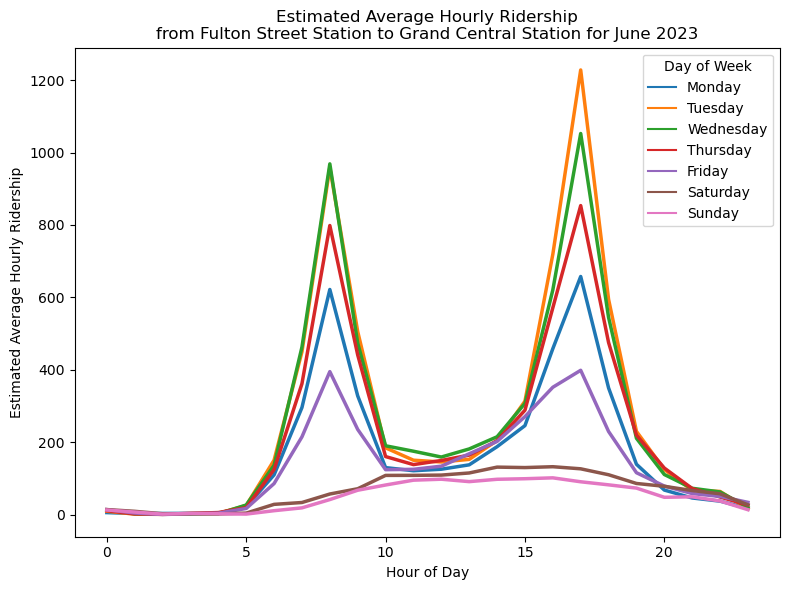

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=grand_central_destination,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Average Hourly Ridership\nfrom Fulton Street Station to Grand Central Station for June 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()   
plt.savefig('figures/fulton-grand-central-june.png', dpi=200, bbox_inches='tight')

Figure 3: Estimated Average Hourly Ridership from Fulton Street Station to Grand Central Station for May 2023.

# Case Study: Yankee Stadium Station

In [30]:
yankee_stadium = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = '161 St-Yankee Stadium (B,D,4)'
        AND origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND month = 8
    ORDER BY estimated_average_ridership DESC
""").df()

yankee_stadium

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",325.1982,8,Friday,17
1,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",281.5517,8,Friday,18
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",240.8378,8,Saturday,18
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",231.2684,8,Wednesday,18
4,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",230.5965,8,Saturday,11
...,...,...,...,...,...,...
152,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.3140,8,Saturday,3
153,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.3077,8,Friday,3
154,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.2858,8,Monday,3
155,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.2666,8,Tuesday,4


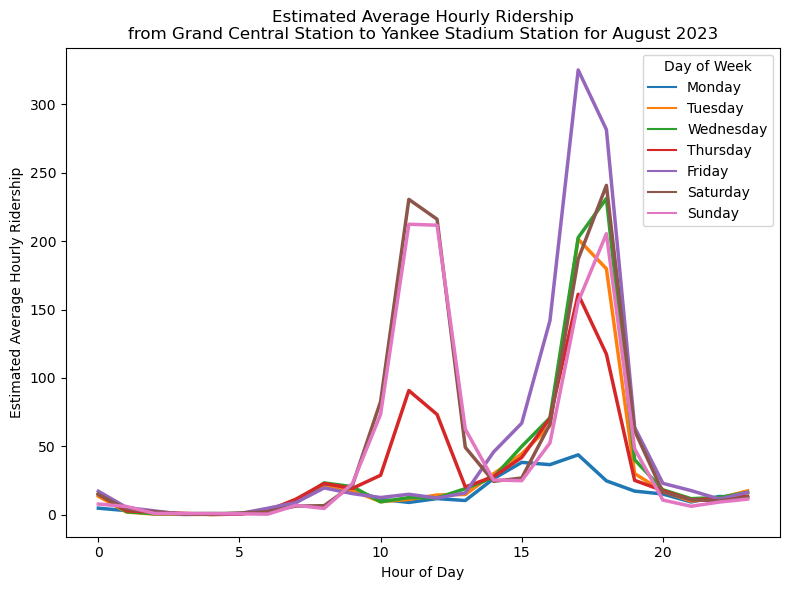

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=yankee_stadium,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Average Hourly Ridership\nfrom Grand Central Station to Yankee Stadium Station for August 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout() 
plt.savefig('figures/grand-central-yankees-august.png', dpi=200, bbox_inches='tight')

Figure 4: Estimated Average Hourly Ridership from Grand Central Station to Yakee Stadium Stadium for August 2023.

In [32]:
# close DuckDB connection
con.close()